***
<font size="6"><center><b> Caspsule Networks (CIFAR100_JUST FINE CLASS_BASED ON PAPER) </b></center></font>
***

# Import Necessary libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

DONE loading MixUp Data generator
DONE loading MixUp Data generator


In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = 30BFPC1AXW95
• Working Directory = C:\Users\knoor\OneDrive - Deakin University\Deep Learning with Python\HDeep_CapsNet\code\Training_and_Analysis\5 CIFAR-100
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : py38tf


## For GPU growth (not required if GPU does not give any error)

In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "0" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  0
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


# Training Parameters

In [4]:
train_params = {"n_epochs" : 100,
                "batch_size": 8,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

# Import Dataset : CIFAR-100

In [5]:
dataset = datasets.CIFAR100(version = 'ALL') # importing CIFAR10 Dataset

CIFAR-100 dataset: Training have 50,000 samples and testing have 10,000 samples


# Build the CapsNet architecture

## - Configuation parameters

In [6]:
caps1_n_maps = 64
caps1_n_caps = caps1_n_maps * 6 * 6
caps1_n_dims = 8
conv1_params = {
    "filters": 256,
    "kernel_size": 9,
    "strides": 1,
    "padding": "valid",
    "activation": tf.nn.relu,
}
conv2_params = {
    "filters": caps1_n_maps * caps1_n_dims,
    "kernel_size": 9,
    "strides": 3,
    "padding": "valid",
    "activation": tf.nn.relu
}
n_class_fine=100
caps2_n_caps_fine = n_class_fine
caps2_n_dims = 16

n_hidden1 = 512
n_hidden2 = 1024
n_output = 30 * 30

## Connect layers

In [7]:
# clear session
tf.keras.backend.clear_session()

def get_compiled_model():
    image_shape = dataset['x_train'].shape[1:]
    # Input image
    x_input = keras.layers.Input(shape=image_shape, name="Input_Image")

    # Layer 1 and 2: Two conventional Conv2D layer
    # input [batch_size, 28, 28, 1], output [batch_size, 6, 6, 256]
    conv1 = keras.layers.Conv2D(name='conv1', **conv1_params)(x_input)
    conv2 = keras.layers.Conv2D(name='conv2', **conv2_params)(conv1)

    # Layer 3: Reshape to 8D primary capsules 
    # input [batch_size, 6, 6, 256], output [batch_size, 1152, 8]
    reshape1 = keras.layers.Reshape((caps1_n_caps, caps1_n_dims), name="reshape_layer")(conv2)

    # Layer 3: Squash to normalize length of each primary capsule vector
    # input [batch_size, 1152, 8], output [batch_size, 1152, 8]
    squash1 = keras.layers.Lambda(models.squash, name='squash_layer')(reshape1)

    # Layer 4.1: Digit capsule layer with routing by agreement
    # input [batch_size, 1152, 8], output [batch_size, 10, 16]
    digitcaps_fine = models.SecondaryCapsule(n_caps=caps2_n_caps_fine, n_dims=caps2_n_dims, 
                        name="Digit_Caps_fine")(squash1)

    # Layer 5.1: Compute the length of each capsule vector
    # input [batch_size, 10, 16], output [batch_size, 10]
    fine_pred_layer = models.LengthLayer(name='Fine_prediction_output_layer')(digitcaps_fine)


    # Decoder network.
    n_hidden1 = 512
    n_hidden2 = 1024
    n_output = np.prod(image_shape) # 28 * 28

    fine_input = keras.Input(shape=(n_class_fine,), name="fine_image_label")

    # Mask layer
    # input [batch_size, 10], output [batch_size, 160]

    decoder_input_fine = models.Mask(name='Mask_input_fine')([digitcaps_fine, fine_input, fine_pred_layer]) 

    # Decoder_fine
    # input [batch_size, 160], output [batch_size, 28, 28, 1]
    decoder_fine = keras.models.Sequential(name='Decoder_fine')
    decoder_fine.add(keras.layers.Dense(n_hidden1, activation='relu', input_dim=caps2_n_dims*n_class_fine))
    decoder_fine.add(keras.layers.Dense(n_hidden2, activation='relu'))
    decoder_fine.add(keras.layers.Dense(n_output, activation='sigmoid'))
    decoder_fine.add(keras.layers.Reshape(target_shape=image_shape, name='recon_output_layer_fine'))

    fine_decoder= decoder_fine(decoder_input_fine)

    # Capsnet model
    model = keras.Model(
        inputs= [x_input, fine_input],
        outputs= [fine_pred_layer, fine_decoder],
        name='capsnet_tf2.X')
    
    model.compile(
        optimizer='adam',
        loss=[model_params['loss_function'],
              'mse'],
        loss_weights=[0.9995, 0.0005],
        metrics={'Fine_prediction_output_layer': 'accuracy'}
    )
    return model

## Compile Model

In [8]:
#Single GPU
model = get_compiled_model()

# Model Summary

In [9]:
model.summary()

Model: "capsnet_tf2.X"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 24, 24, 256)  62464       ['Input_Image[0][0]']            
                                                                                                  
 conv2 (Conv2D)                 (None, 6, 6, 512)    10617344    ['conv1[0][0]']                  
                                                                                                  
 reshape_layer (Reshape)        (None, 2304, 8)      0           ['conv2[0][0]']                  
                                                                                      

## Log Directory

In [10]:
directory = sysenv.log_dir('CapsNet')

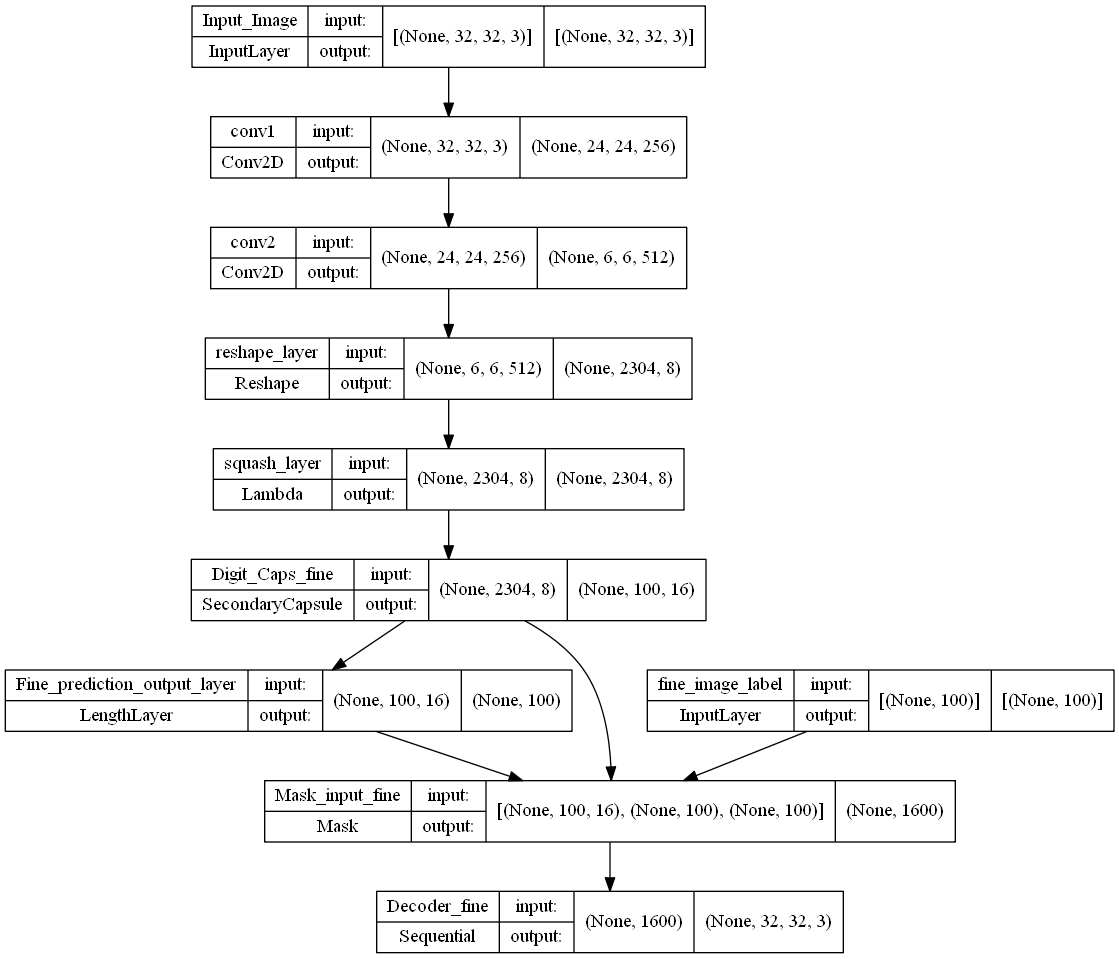

In [11]:
keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

## Callbacks

In [12]:
tb = keras.callbacks.TensorBoard(directory+'/tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))

log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/weights-best.h5',  
    monitor='val_loss',
    save_best_only=True, save_weights_only=True, verbose=1)

lr_decay = keras.callbacks.LearningRateScheduler(
    schedule=lambda epoch: train_params["lr"] * (train_params["lr_decay"] ** epoch))

# Run training

## Training

In [13]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(x=[dataset['x_train'], dataset['y_train_fine']],
                    y=[dataset['y_train_fine'], dataset['x_train']],
                    batch_size = train_params["batch_size"],
                    epochs = train_params["n_epochs"],
                    validation_data=([dataset['x_test'], dataset['y_test_fine']],
                                    [dataset['y_test_fine'], dataset['x_test']]),
                    callbacks =[tb, log, checkpoint, lr_decay],
                    verbose="auto")
    
    model.save_weights(model_save_dir)

# Model evaluate

In [14]:
print(model.metrics_names)

[]


In [15]:
results = model.evaluate([dataset['x_test'], dataset['y_test_fine']],
                         [dataset['y_test_fine'], dataset['x_test']],
                         verbose=1)

313/313 [==============================] - 36s 99ms/step - loss: 0.5039 - Fine_prediction_output_layer_loss: 0.5036 - Decoder_fine_loss: 1.0248 - Fine_prediction_output_layer_accuracy: 0.3493


In [16]:
for n in range(len(results)):
    print(n+1,'_',model.metrics_names[n], '==>', results[n],'\n')

1 _ loss ==> 0.5038942098617554 

2 _ Fine_prediction_output_layer_loss ==> 0.5036336779594421 

3 _ Decoder_fine_loss ==> 1.0247931480407715 

4 _ Fine_prediction_output_layer_accuracy ==> 0.34929999709129333 



# Model Prediction

In [17]:
predictions = model.predict([dataset['x_test'], dataset['y_test_fine']],
                            verbose=1
                           )

313/313 [==============================] - 30s 93ms/step


In [18]:
print('\033[91m','\033[1m',"\nModel prediction array shape:", '\033[0m')
for n in range(len(predictions)):
    print("predictions[{0}]:".format(n), predictions[n].shape)

  
Model prediction array shape: 
predictions[0]: (10000, 100)
predictions[1]: (10000, 32, 32, 3)


# Analysis

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37',

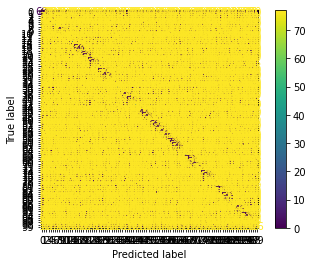

              precision    recall  f1-score   support

           0    0.55200   0.69000   0.61333       100
           1    0.38281   0.49000   0.42982       100
           2    0.24752   0.25000   0.24876       100
           3    0.17949   0.14000   0.15730       100
           4    0.25806   0.24000   0.24870       100
           5    0.21905   0.23000   0.22439       100
           6    0.28037   0.30000   0.28986       100
           7    0.34951   0.36000   0.35468       100
           8    0.35556   0.32000   0.33684       100
           9    0.51807   0.43000   0.46995       100
          10    0.30159   0.19000   0.23313       100
          11    0.30137   0.22000   0.25434       100
          12    0.38000   0.38000   0.38000       100
          13    0.24000   0.24000   0.24000       100
          14    0.24000   0.24000   0.24000       100
          15    0.21296   0.23000   0.22115       100
          16    0.44928   0.31000   0.36686       100
          17    0.38816   0

In [19]:
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score

fine_classes_number = n_class_fine

y_true_fine = np.argmax(dataset['y_test_fine'], axis=1)
y_pred_fine = np.argmax(predictions[0], axis=1)

output = set()
for x in y_true_fine:
    output.add(x)
print(output)

fine_labels = list(range(0, fine_classes_number))
fine_target_names = [str(x) for x in list(range(0, fine_classes_number))]

print(fine_labels)
print(fine_target_names)

def confusion_matrixDisplay(y_true, y_pred, target_names):
    labels = target_names
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=labels).plot()
    plt.show()
    #plt.savefig("Confusion_Matrix.png")

print('\n\033[91m','\033[1m',"\u2022",'multilabel-Confusion_Matrix','\033[0m\n')

print('\n\033[91m','\033[1m',"\u2022",'FINE LEVEL','\033[0m')
print(multilabel_confusion_matrix(y_true_fine, y_pred_fine))

print('\n\033[91m','\033[1m',"\u2022",'Confusion_Matrix','\033[0m\n')


print('\n\033[91m','\033[1m',"\u2022",'FINE LEVEL','\033[0m')
print(confusion_matrix(y_true_fine, y_pred_fine))

print('\n\033[91m','\033[1m',"\u2022",'Classification Report','\033[0m\n')

print('\n\033[91m','\033[1m',"\u2022",'FINE LEVEL','\033[0m')
confusion_matrixDisplay(y_true_fine, y_pred_fine, fine_target_names)
print(classification_report(y_true_fine, y_pred_fine, target_names=fine_target_names, digits=5))

## Hierarchical Metrics

In [20]:
tree = Tree()
tree.create_node("Root", "root")  # root node
for i in range(n_class_fine):
    tree.create_node(i, 'L0_'+ str(i), parent="root")
tree.show()

Root
├── 0
├── 1
├── 2
├── 3
├── 4
├── 5
├── 6
├── 7
├── 8
├── 9
├── 10
├── 11
├── 12
├── 13
├── 14
├── 15
├── 16
├── 17
├── 18
├── 19
├── 20
├── 21
├── 22
├── 23
├── 24
├── 25
├── 26
├── 27
├── 28
├── 29
├── 30
├── 31
├── 32
├── 33
├── 34
├── 35
├── 36
├── 37
├── 38
├── 39
├── 40
├── 41
├── 42
├── 43
├── 44
├── 45
├── 46
├── 47
├── 48
├── 49
├── 50
├── 51
├── 52
├── 53
├── 54
├── 55
├── 56
├── 57
├── 58
├── 59
├── 60
├── 61
├── 62
├── 63
├── 64
├── 65
├── 66
├── 67
├── 68
├── 69
├── 70
├── 71
├── 72
├── 73
├── 74
├── 75
├── 76
├── 77
├── 78
├── 79
├── 80
├── 81
├── 82
├── 83
├── 84
├── 85
├── 86
├── 87
├── 88
├── 89
├── 90
├── 91
├── 92
├── 93
├── 94
├── 95
├── 96
├── 97
├── 98
└── 99



In [21]:
true_label = [y_true_fine.tolist()]
pred_label = [predictions[0]]

In [22]:
h_measurements = metrics.get_hierarchical_metrics(true_label, pred_label, tree)
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2])
print('\nH Accuracy=',
     metrics.get_h_accuracy(true_label, pred_label),
     '\nThis method computes the harmonic mean of accuracies of all level in the taxonomy.',)

print('\nM Accuracy=',
     metrics.get_m_accuracy(true_label, pred_label),
     '\nThis method computes the harmonic mean of accuracies of all level in the taxonomy.',
      )

print('\nExact_Match=',
     metrics.get_exact_match(true_label, pred_label),
     '\nThis method compute the exact match score. Exact match is defined as the #of examples for which the predictions for all level in the taxonomy is correct by the total #of examples.',
      )

print('\nConsistency=',
     metrics.get_consistency(pred_label, tree),
     '\nThis methods estimates the consistency.',
      )


Hierarchical Precision = 0.3493 
Hierarchical Recall = 0.3493 
Hierarchical F1-Score = 0.3493

H Accuracy= 0.3493 
This method computes the harmonic mean of accuracies of all level in the taxonomy.

M Accuracy= 0.3493 
This method computes the harmonic mean of accuracies of all level in the taxonomy.

Exact_Match= 0.3493 
This method compute the exact match score. Exact match is defined as the #of examples for which the predictions for all level in the taxonomy is correct by the total #of examples.

Consistency= 1.0 
This methods estimates the consistency.
